<font size="6">**Seasonality**</font>

In [1]:

import numpy as np
import seaborn as sns

from sklearn.model_selection import (TimeSeriesSplit, cross_validate)
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

running notebook configuration


In [4]:
from src.load_data import market_data
from src.mle import time_series as mle_ts
from src import utils

# Parameters

In [5]:
KFOLDS = 3

In [6]:
def wrap_cv_res(cv_res, label, score, factor=-1):
    cv_res_df = pd.DataFrame(cv_res).rename(columns={'test_score': f'cv_test_{score}'})
    cv_res_df.index.name = "kfold"
    cv_res_df['model'] = label
    cv_res_df.set_index('model',append=True, inplace=True)
    cv_res_df[ f'cv_test_{score}'] *= factor

    return cv_res_df

In [7]:
def get_preds(X: pd.DataFrame, model, name='preds'):
    return pd.Series(index=X.index, data=model.predict(X), name=name)
    

# Load Data

In [8]:
cnmc_df = market_data.read_cnmc_data()[['cons_GOA']] * 1e-6

In [9]:
cnmc_df['month'] = cnmc_df.index.month
cnmc_df['qtr'] = cnmc_df.index.quarter

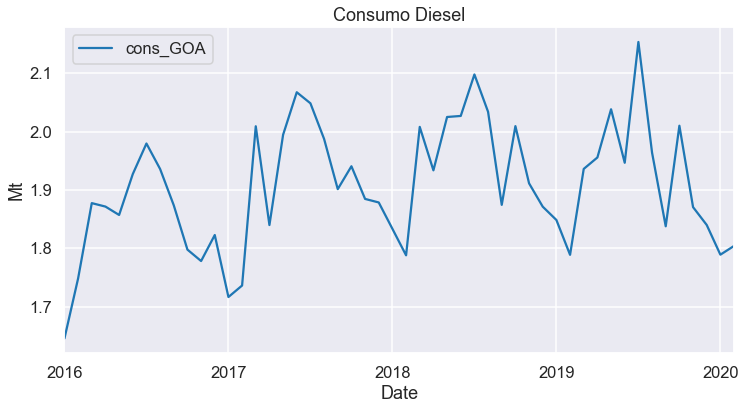

In [10]:
cnmc_df.plot(y='cons_GOA', title='Consumo Diesel')
plt.ylabel("Mt")
plt.show()

# Time Series Split

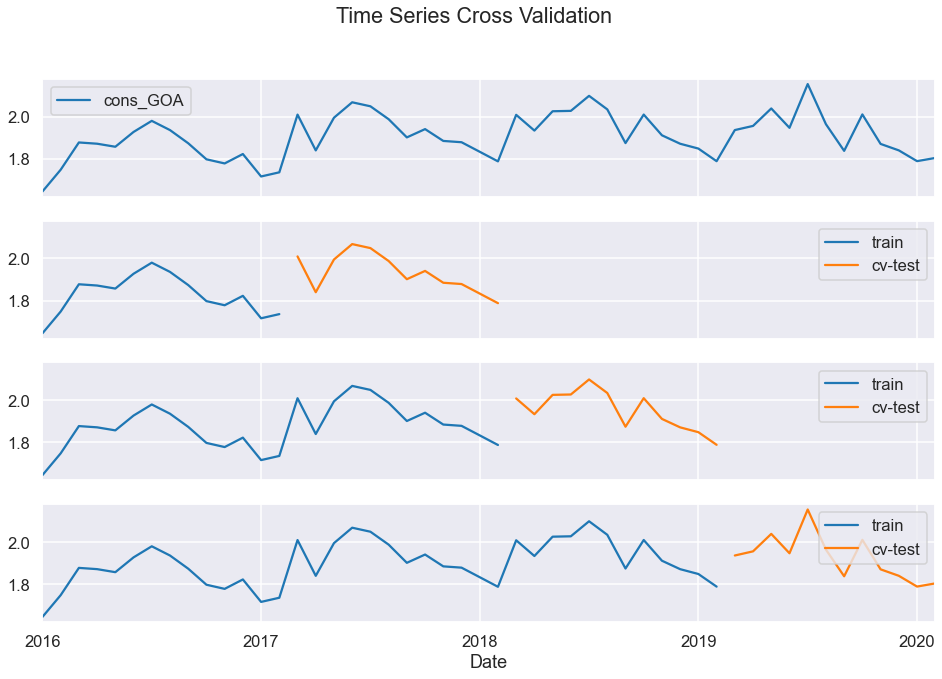

In [11]:
tscv = TimeSeriesSplit(n_splits=KFOLDS)
sp_tscv  = tscv.split(cnmc_df['cons_GOA'])

fig, axs = plt.subplots(KFOLDS+1, 1, sharex=True, sharey=True, figsize=(16,10))

ax = axs[0]
cnmc_df.plot(y='cons_GOA', ax=ax)

for idx_row, (train_index, test_index) in enumerate(sp_tscv):
    ax = axs[idx_row+1]
    cnmc_df.iloc[train_index].plot(y='cons_GOA', label='train', ax=ax)
    cnmc_df.iloc[test_index].plot(y='cons_GOA', label='cv-test' , ax=ax)

plt.suptitle('Time Series Cross Validation')
plt.show()

# Seasonal Models

In [12]:
seas_ohe_model = LinearRegression(fit_intercept=True)
tscv = TimeSeriesSplit(n_splits=KFOLDS)

seas_ohe_qtr_cv = cross_validate(
    seas_ohe_model,
    X=pd.get_dummies(cnmc_df['qtr'], drop_first=True),
    y=cnmc_df['cons_GOA'],
    scoring='neg_mean_squared_error', cv=tscv)

In [13]:
seas_cv_res_df1 =  wrap_cv_res(seas_ohe_qtr_cv, score='mse', label='ohe_qtr')

In [14]:
seas_wave_model = LinearRegression(fit_intercept=True)
tscv = TimeSeriesSplit(n_splits=KFOLDS)

seas_wave_cv1 = cross_validate(
    seas_wave_model,
    X=mle_ts.get_wave_features(cnmc_df['month'].astype(int), periods=[12], n_harmonics=1),
    y=cnmc_df['cons_GOA'],
    scoring='neg_mean_squared_error', cv=tscv)

In [15]:
seas_cv_res_df2 =  wrap_cv_res(seas_wave_cv1, score='mse', label='wave2')

In [16]:
seas_cv_res_df = pd.concat([seas_cv_res_df1, seas_cv_res_df2], axis=0)
seas_cv_res_df.sample(5)

fit_time  score_time  cv_test_mse
kfold model                                     
0     ohe_qtr    0.0078      0.0030       0.0149
1     ohe_qtr    0.0053      0.0037       0.0110
2     ohe_qtr    0.0049      0.0040       0.0078
      wave2      0.0060      0.0039       0.0054
0     wave2      0.0070      0.0040       0.0116

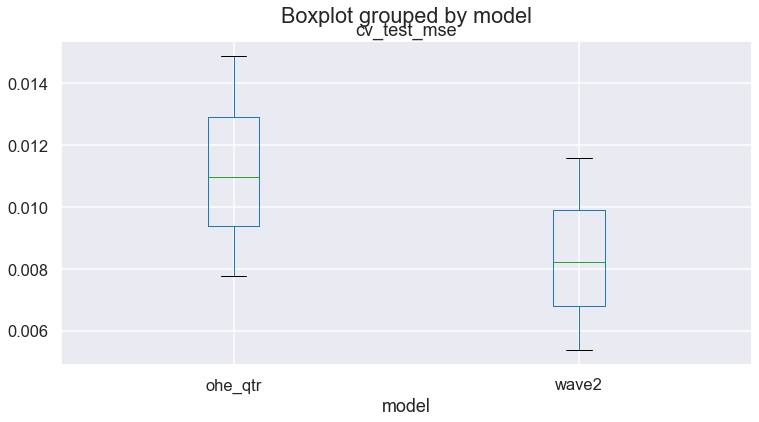

In [17]:
seas_cv_res_df.boxplot('cv_test_mse', by='model')
plt.show()

In [18]:
y = cnmc_df['cons_GOA']

p_diff = cnmc_df['cons_GOA'].diff(12)

In [19]:
X_train = cnmc_df.loc[:'2018', ['month', 'qtr']].copy()
X_test = cnmc_df.loc['2019', ['month', 'qtr']].copy()

In [20]:
X_train_ohe = pd.get_dummies(X_train['qtr'], drop_first=True)
X_test_ohe = pd.get_dummies(X_test['qtr'], drop_first=True)

In [21]:
X_train_wave = mle_ts.get_wave_features(X_train['month'], periods=12, n_harmonics=1)
X_test_wave = mle_ts.get_wave_features(X_test['month'], periods=12, n_harmonics=1)

TypeError: 'int' object is not iterable

In [ ]:
y_train = cnmc_df.loc[:'2018', 'cons_GOA'].copy()
y_test = cnmc_df.loc['2019', 'cons_GOA'].copy()

In [ ]:
seas_ohe_model = LinearRegression(fit_intercept=True)

seas_ohe_model = seas_ohe_model.fit(X_train_ohe, y_train)
p_train_ohe = get_preds(X_train_ohe, seas_ohe_model, name='p_train_ohe')
p_test_ohe = get_preds(X_test_ohe, seas_ohe_model, name='p_test_ohe')

In [ ]:
seas_wave_model = LinearRegression(fit_intercept=True)

seas_ohe_model = seas_wave_model.fit(X_train_wave, y_train)
p_train_wave = get_preds(X_train_wave, seas_wave_model, name='p_train_wave')
p_test_wave = get_preds(X_test_wave, seas_wave_model, name='p_test_wave')

In [ ]:
p_ohe = pd.concat([p_train_ohe, p_test_ohe], axis=0)
p_ohe.name = 'p_ohe'
p_wave = pd.concat([p_train_wave, p_test_wave], axis=0)
p_wave.name = 'p_wave'

In [ ]:
ax = cnmc_df.plot(y='cons_GOA', label='y_true')

p_ohe.plot(ax=ax)
p_wave.plot(ax=ax)
plt.axvline(pd.Timestamp('2019'), linestyle='--', color='black', linewidth=1)

plt.title('Consumo Diesel: Modelos Estacionales')
plt.legend()
plt.show()

In [ ]:
p_ohe_adj = y - p_ohe
p_wave_adj = y - p_wave

In [ ]:
ax = p_ohe_adj.plot(label='ohe')
p_wave_adj.plot(label='wave', ax=ax)
p_diff.plot(label='d12', ax=ax)
plt.legend()
plt.show()